# Total Process

- MNIST
- DataLoader, Transformation
- Multilayer Neural Net, activation function
- Loss and Optimizer
- Traninig Loop (batch training)
- Model evaluation
- GPU support

## Settings

In [86]:
# import
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device config
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # 28 * 28
hidden_size = 100
num_class = 10
num_epochs = 10
batch_size = 100
learning_rate = 0.001
split_ratio = 0.8

In [44]:
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(4)
torch.cuda.manual_seed(4)
torch.cuda.manual_seed_all(4)
random.seed(4)

## 0) Prepare Dataset

In [71]:
# 0) Prepare Dataset

## transform
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

## data
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        transform=mnist_transform,
                                        download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        transform=mnist_transform,
                                        download=True)



# train, valid split
print(len(train_dataset))
train_num = int(len(train_dataset) * split_ratio)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, len(train_dataset)-train_num])


## dataloader
trainloader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
validloader = DataLoader(dataset=valid_dataset,
                        batch_size=batch_size,
                        shuffle=False)
testloader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


60000


In [80]:
# sample test
examples = iter(trainloader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [83]:
# sample test2
examples = iter(testloader)
samples, labels = examples.next()
print(samples.shape, labels.shape)
labels

torch.Size([64, 1, 28, 28]) torch.Size([64])


tensor([1, 0, 2, 6, 3, 9, 0, 1, 2, 9, 1, 5, 9, 7, 5, 5, 0, 3, 6, 9, 9, 8, 2, 0,
        4, 3, 0, 3, 3, 1, 0, 2, 6, 7, 1, 4, 5, 7, 8, 1, 8, 7, 9, 0, 8, 6, 7, 3,
        9, 8, 2, 4, 2, 0, 9, 8, 0, 7, 2, 2, 6, 4, 5, 2])

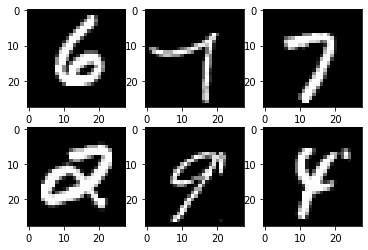

In [81]:
# show image
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

## 1) Model

In [66]:
# 1) Model
class MNISTclassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNISTclassification, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out


In [67]:
model = MNISTclassification(input_size=input_size, hidden_size=hidden_size, num_classes=num_class)

## 2) Loss and Optimizer

In [75]:
# 2) Loss and Optimizer
learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)

## 3) Training Loop

In [87]:
# 3) Training Loop
train_loss = []
valid_loss = []
n_total_steps = len(trainloader)
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    model.train()
    total_loss = 0
    print("Train")
    for i, (images, labels) in enumerate(trainloader):
        # reshape
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)

        # loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        
        # reset
        optimizer.zero_grad()
        # backprop
        loss.backward()
        # update
        optimizer.step()
        
        
        # print
        if (i+1) % 100 ==0:
            print(f"iter {epoch+1}/{num_epochs}, step {i+1} /{n_total_steps} : train_loss = {loss.item():.4f}")
    print(f"avg_train_loss={total_loss/len(trainloader):.4f}")
    train_loss.append(total_loss/len(trainloader))
    
    
    print("Eval")
    with torch.no_grad():
        model.eval()
        total_loss_val = 0
        n_samples = 0
        n_correct = 0
        for j, (images, labels) in enumerate(validloader):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)

            # predictions # return : max_value, max_index
            _, predictions = torch.max(outputs, 1)
            n_samples += labels.shape[0]
            n_correct += (predictions==labels).sum().item()

            # loss
            loss_val = criterion(outputs, labels)
            total_loss_val+=loss_val.item()
        
        acc = 100.0 * n_correct / n_samples
        print(f"avg_valid_loss={total_loss_val/len(validloader):.4f}, acc = {acc}")
        valid_loss.append(total_loss_val/len(validloader))


Epoch 0
Train
iter 1/10, step 100 /750 : train_loss = 0.6158
iter 1/10, step 200 /750 : train_loss = 0.5617
iter 1/10, step 300 /750 : train_loss = 0.4358
iter 1/10, step 400 /750 : train_loss = 0.4681
iter 1/10, step 500 /750 : train_loss = 0.4589
iter 1/10, step 600 /750 : train_loss = 0.6263
iter 1/10, step 700 /750 : train_loss = 0.5341
avg_train_loss=0.5382
Eval
avg_valid_loss=0.5266, acc = 86.94166666666666
Epoch 1
Train
iter 2/10, step 100 /750 : train_loss = 0.3874
iter 2/10, step 200 /750 : train_loss = 0.4904
iter 2/10, step 300 /750 : train_loss = 0.4254
iter 2/10, step 400 /750 : train_loss = 0.4760
iter 2/10, step 500 /750 : train_loss = 0.4990
iter 2/10, step 600 /750 : train_loss = 0.5735
iter 2/10, step 700 /750 : train_loss = 0.4114
avg_train_loss=0.5144
Eval
avg_valid_loss=0.5054, acc = 87.19166666666666
Epoch 2
Train
iter 3/10, step 100 /750 : train_loss = 0.4131
iter 3/10, step 200 /750 : train_loss = 0.6181
iter 3/10, step 300 /750 : train_loss = 0.5179
iter 3/10, 

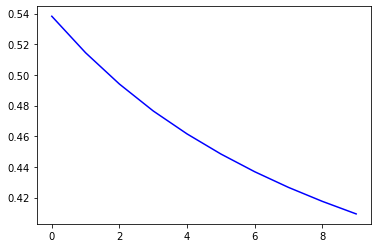

In [88]:
# plot
import matplotlib.pyplot as plt
plt.plot(train_loss, color="b")
plt.show()

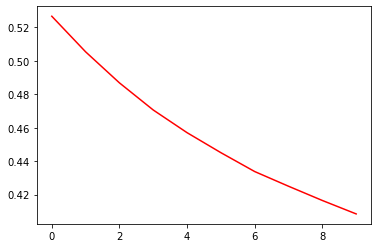

In [89]:
plt.plot(valid_loss, color="r")

## 4) Test

In [ ]:
# 4) Test
model.eval()
for i, (x_test, y_test) in enumerate(testloader):
    
    x_test = x_test.view(-1, 1 * 28 * 28)

    y_pred = model(x_test)
    y_pred_class = torch.argmax(y_pred, axis=1)
    
    for 
